In [1]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA or MPS is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA for NVIDIA GPU
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple's MPS
    print("Using Apple MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")
print(f"Running on device: {device}")

Using Apple MPS (Metal Performance Shaders)
Running on device: mps


In [2]:
# Data prep

# Define transformations: Convert to Tensor and normalize images

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize between [-1, 1]
])


# Download and load the training and testing datasets

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

print(train_dataset)
print(train_loader)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
# Option #2: use a CNN

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1 input channel (grayscale), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 12 * 12, 128) # 12x12 from Conv2D layer
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu_(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Initialize the CNN model, criterion, and optimizer

model_cnn = CNN()
model_cnn.to(device=device)

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

print(device)

mps


Epoch [1/5], Loss: 0.3996
Epoch [2/5], Loss: 0.1911
Epoch [3/5], Loss: 0.1394
Epoch [4/5], Loss: 0.1112
Epoch [5/5], Loss: 0.0943
Finished Training


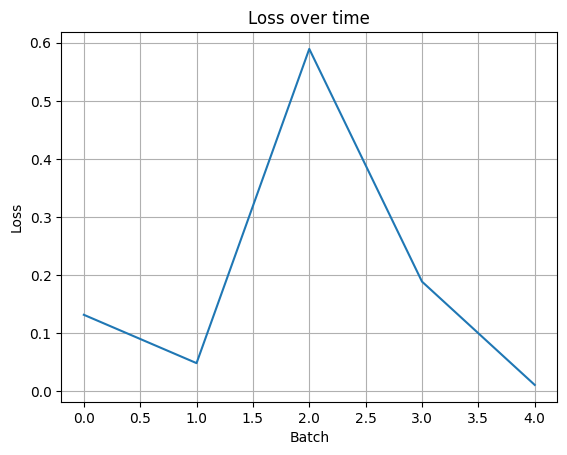

Epoch [1/5], Loss: 0.1287
Epoch [2/5], Loss: 0.0402
Epoch [3/5], Loss: 0.0249
Epoch [4/5], Loss: 0.0172
Epoch [5/5], Loss: 0.0107
Finished Training


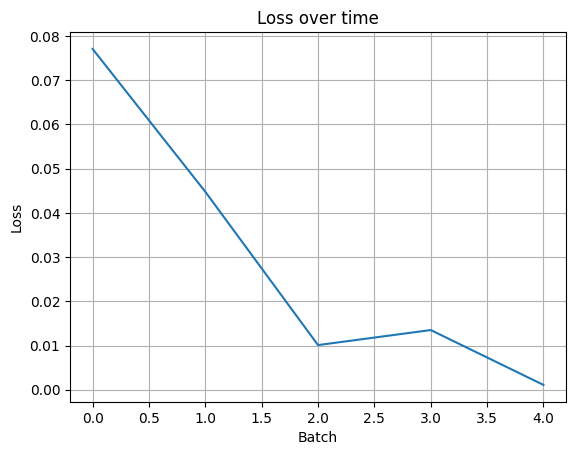

In [6]:
# Training loop for fcn

num_epochs = 5
loss_arr =  np.array([])
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Move data (images and labels) to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer_cnn.zero_grad()
        
        # Forward pass
        outputs = model_cnn(images)
        loss = criterion_cnn(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()

    loss_arr = np.append(loss_arr, loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

plt.plot(loss_arr)
plt.title('Loss over time')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [8]:
# Evaluate the models
model_cnn.eval() # Set model to evaluation mode (disables dropout, batchnorm, etc.)

correct_cnn = 0
correct_fcn = 0
total = 0
with torch.no_grad(): # Disable gradient computation for testing
    for images, labels in test_loader:
        # Move data (images and labels) to GPU
        images, labels = images.to(device), labels.to(device)

        outputs_cnn = model_cnn(images)
        _, predicted = torch.max(outputs_cnn.data, 1)
        total += labels.size(0)
        correct_cnn += (predicted==labels).sum().item()

        outputs_fcn = model_fcn(images)
        _, predicted_fcn = torch.max(outputs_fcn.data, 1)
        correct_fcn += (predicted_fcn==labels).sum().item()

accuracy_cnn = 100 * correct_cnn / total
accuracy_fcn = 100 * correct_fcn / total
print(f'Accuracy of the model on the 10,000 test images: {accuracy_fcn:.2f}%')
print(f'Accuracy of the model on the 10,000 test images: {accuracy_cnn:.2f}%')


RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

In [8]:
torch.save(model_cnn.state_dict(), 'mnist_cnn_model.pth')
model_cnn.load_state_dict(torch.load('mnist_cnn_model.pth'))


/var/folders/_m/p9lrk0vj7l9dgy03bgtt6sm80000gn/T/ipykernel_7633/554289439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('mnist_cnn

<All keys matched successfully>